  0%|          | 0/5 [00:00<?, ?it/s]

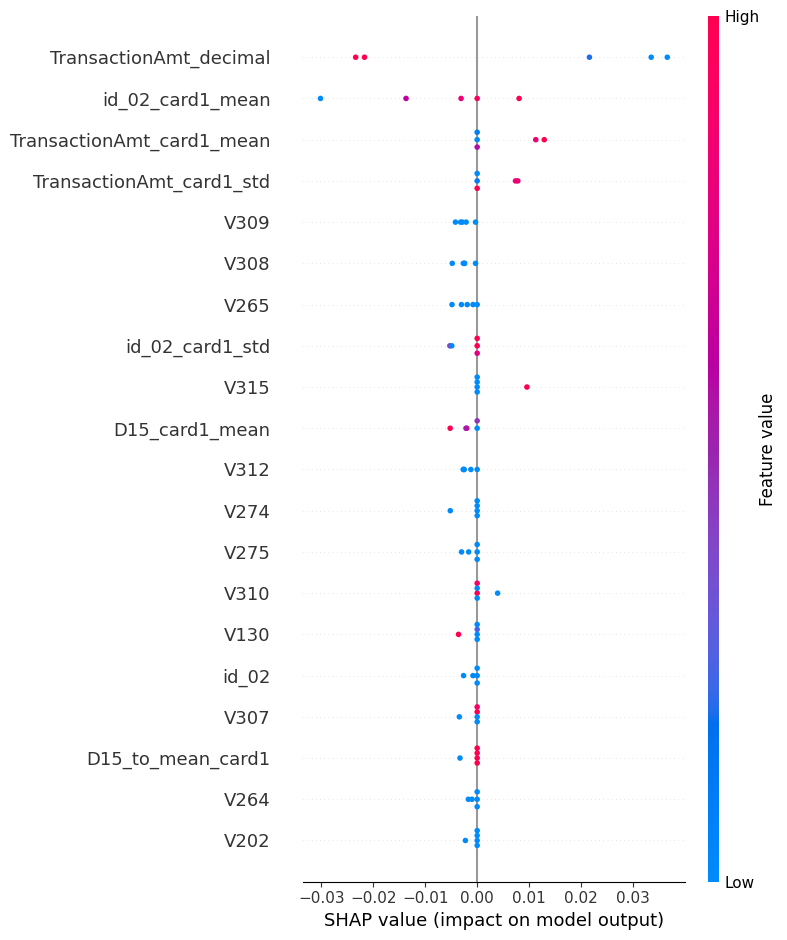

In [3]:
import pandas as pd
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
import sys

# 1. Setup Environment & Model
sys.path.append('../src')
from model import MultiTaskTabNet

# Parameters must match your training/eval
shared_dim = 50
device = torch.device('cpu')

# 2. Load Data for Explanation
# We'll use a small slice of the engineered training data
df = pd.read_parquet('../data/processed/train.parquet').sample(500, random_state=42)
X_eval = df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1).fillna(-999).astype(np.float32)

# 3. Initialize and Load Model
input_dim = shared_dim
private_dim = X_eval.shape[1] - shared_dim

model = MultiTaskTabNet(input_dim=input_dim, private_dim=private_dim)
model.load_state_dict(torch.load('../outputs/models/unified_mtl_best.pth', map_location=device))
model.eval()

# 4. Define SHAP Wrapper
def model_predict(inputs):
    inputs_torch = torch.tensor(inputs, dtype=torch.float32)
    s = inputs_torch[:, :shared_dim]
    p = inputs_torch[:, shared_dim:]
    with torch.no_grad():
        _, fraud_p = model(s, p)
    return fraud_p.numpy().flatten() # Flatten is key for SHAP

# 5. Execute SHAP (Warning: KernelExplainer is slow on CPU)
# We use 20 samples as a background and explain 5 instances
background = X_eval.values[:20]
test_instances = X_eval.values[20:25]

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(test_instances)

# 6. Plot
shap.summary_plot(shap_values, X_eval.iloc[20:25], feature_names=X_eval.columns)